# **Neural Networks & Intelligent Systems**
## **ECE NTUA, Flow Y, 9th Semester, 2021-2022**
### *Lab 3: Deep Learning (Image Captioning)*

#### Team 20

### Image Captioning with Neural Networks

The Dataset is called "flickr30k-images-ecemod". It is a modification of flick30k. In flickr30k-images-ecemod each images has 5 captions. Specifically, it consists of: 
* the folder "image_dir" with 31.783 images from Flickr
* the file "train_captions.csv" with 148.915 captions for the images of "image_dir"
* the "test_images.csv" with 2.000 image names from "imag_dir" tha do not have training captions

[Notebook Source](https://www.tensorflow.org/tutorials/text/image_captioning)

### Installation of packages & libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import pandas as pd
import json
from PIL import Image
from tqdm import tqdm
from tqdm import notebook
import re
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import math
import sys
import gensim
import gensim.downloader as api
import warnings

### Dataset introduction

In the following cells, we download the dataset for the modeling of our NN:
* (31.782 + 1 read_me.txt) in the folder _image_dir_
* the _train_captions.csv_ tha include the paths for the images in the folder _image_dir_ with their captions
* the _test_images.csv_ that include the paths for the images in the folder _image_dir_ that do not have training captions

In [ ]:
# Download image files
image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                      extract=True)
os.remove(image_zip)

4376395776/4376381805 [==============================] - 206s 0us/step


In [ ]:
# Download train captions file
train_captions_file = tf.keras.utils.get_file('train_captions.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/train_captions.csv',
                                           extract=False)

# Download test files list
test_images_file = tf.keras.utils.get_file('test_images.csv',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='https://spartacus.1337.cx/flickr-mod/test_images.csv',
                                           extract=False)

40960/29242 [==========================================] - 0s 0us/step


### Έπειτα κάνουμε mount ένα drive για να αποθηκεύουμε ευκολότερα τα δεδομένα μας.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Διαβάζουμε το dataset και παρατηρούμε το περιεχόμενό του.

In [ ]:
dfpath = "/content/drive/MyDrive/NN_lab_3/data/"
captions_df = pd.read_csv(dfpath + "train_captions.csv",header = None, on_bad_lines="skip")
captions_df.head(5)

,0
0,_1000070808.jpg| 0| A little girl holds orange...
1,_1000070808.jpg| 1| A little girl at a wedding...
2,_1000070808.jpg| 2| Young girl in orange dress...
3,_1000070808.jpg| 3| a girl at a wedding holdin...
4,_1000070808.jpg| 4| A girl holds a bouquet of ...


In [ ]:
with open(f"{dfpath}train_captions.csv", 'r') as f:
  captions = []
  for line in f:
    captions.append([ w.strip() for w in line.split("|")])

In [ ]:
captions[11]

['_100008804.jpg',
 '1',
 'A green sign in several languages mentions Facebook and Twitter , while people talk below in the sunlight .']

In [ ]:
image_path_to_caption = collections.defaultdict(list)
PATH = "/content/image_dir/"
for i in captions:
    caption = f"<start> {i[2]} <end>"
    image_path = PATH +i[0]
    image_path_to_caption[image_path].append(caption)

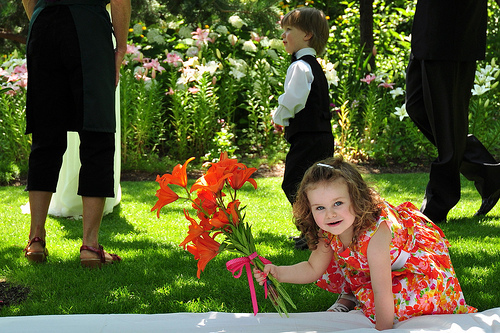

In [ ]:
img_path = "/content/image_dir/_1000070808.jpg"
Image.open(img_path)

This cell chooses a number of Samples for the train set. This procedure may decrease the successful decision of the most accurate caption.

img_name_train_vector:
- containts the paths of the images for the training.
- length: 30.000 (6.000 images x 5 captions)
output: same path

captions_train: 
- length: 30.000 
- by using the indexing of a caption in img_name_train_vector we can see the image

<start> A young child walks down a gravel path lined with a row of red outdoor chairs . <end>


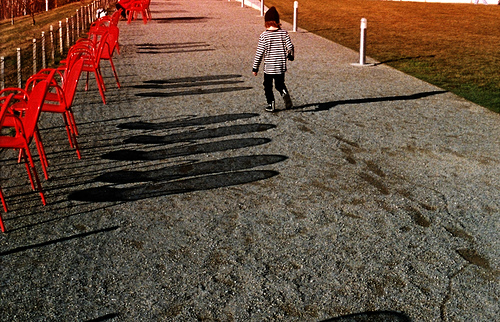

In [ ]:
image_paths = list(image_path_to_caption.keys())[:6000]
train_captions = []
img_name_vector = []

for image_path in image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))


print(train_captions[5])
Image.open(img_name_vector[5])


### Preprocessing : στο βασικό μας μοντέλο, όπου ακολουθούμε το tutorial του tensorflow, χρησιμοποιούμε InceptionV3 για την προεπεξεργασία κάθε εικόνας.

### Load images

For the feature extraction from the final convolutional layer the data should have a InceptionV3 format which means:
- images with 299 x 299 pixels
- pixels should be in (-1,1) with _tf.keras.applications.inception_v3.preprocess_input_


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### InceptionV3 initialization

A _tf.keras_ model is created where its final layer is the last convolutional layer in InceptionV3. It is used because the learning is based on attention
- output_layer is 8 x 8 x 2048 for InceptionV3 or 10 x 10 x 1280 for EfficientNetB1
- each image gives a vector that is saved in (image_name --> feature_vector) and from this dictionary it is saved in the disk

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87924736/87910968 [==============================] - 1s 0us/step


### Caching the features extracted from InceptionV3


In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

### Preprocessing and tokenization

The following cell preprocesses the captions by splitting words-tokens. 
These tokens will be used for the creation of a dictionary, where each word correspond to its index in the vocabulary. Finally, the word-to-index and index-to-word mappings are created in order to visualize the results.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Split the data into train, validation and test set

Based on the tutorial [tutorial](https://www.tensorflow.org/tutorials/text/image_captioning) for TensorFlow.

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

### Create a tf.data dataset for training


In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Neural Models

Based on [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf):

- features are extracted from the final convolutional layer of InceptionV3 and give a vector of (8,8,2048)
- these vectors are then rearranged in (64,2048)
- then they pass through CNN Encoder, which is a fully connected layer
* finally the RNN (GRU) scans iteratively the image in order to predict the caption

Το μοντέλο που θα χρησιμοποιήσουμε έχει την μορφή Encoder - Decoder όπου αρχικά χρησιμοποιούμε ως encoder ένα δίκτυο cnn και ως decoder ένα δίκτυο rnn.

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    
    # self.drp = tf.keras.layers.Dropout(0.45)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

#### Initialize Encoder and Decoder Models

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

### Loss function

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

### Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

### Training 

Ξεκινάμε την εκκαίδευσή μας μεταβάλοντας την τιμή του batch size = [64,32,16] προκειμένου να παρατηρήσουμε τα αποτελέσματα και τους χρόνους ολοκλήρωσης.

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target,encoder, decoder, optimizer):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

#### Main Training

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 2 Batch 0 Loss 0.7116
Epoch 2 Batch 100 Loss 0.8206
Epoch 2 Loss 0.775033
Time taken for 1 epoch 808.89 sec

Epoch 3 Batch 0 Loss 0.7527
Epoch 3 Batch 100 Loss 0.7043
Epoch 3 Loss 0.723574
Time taken for 1 epoch 752.57 sec

Epoch 4 Batch 0 Loss 0.6764
Epoch 4 Batch 100 Loss 0.6966
Epoch 4 Loss 0.673924
Time taken for 1 epoch 749.71 sec

Epoch 5 Batch 0 Loss 0.5980
Epoch 5 Batch 100 Loss 0.6365
Epoch 5 Loss 0.630318
Time taken for 1 epoch 748.08 sec

Epoch 6 Batch 0 Loss 0.6259
Epoch 6 Batch 100 Loss 0.6209
Epoch 6 Loss 0.587968
Time taken for 1 epoch 748.88 sec

Epoch 7 Batch 0 Loss 0.4962
Epoch 7 Batch 100 Loss 0.4837
Epoch 7 Loss 0.549988
Time taken for 1 epoch 748.27 sec

Epoch 8 Batch 0 Loss 0.4799
Epoch 8 Batch 100 Loss 0.5158
Epoch 8 Loss 0.516118
Time taken for 1 epoch 753.34 sec

Epoch 9 Batch 0 Loss 0.4709
Epoch 9 Batch 100 Loss 0.4646
Epoch 9 Loss 0.480770
Time taken for 1 epoch 746.68 sec

Epoch 10 Batch 0 Loss 0.4327
Epoch 10 Batch 100 Loss 0.4924
Epoch 10 Loss 0.4516

#### Plot Train Loss

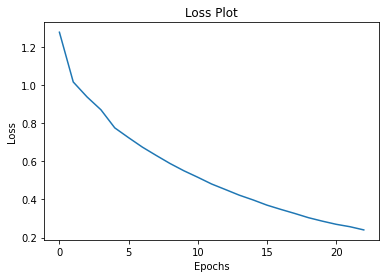

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


### Image Captioning Evaluation

The following cells implement the evaluation of the captions that are predicted
- output: the real caption and the predicted caption from the NN

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (16, 16))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a family sits on the beach together <end>
Prediction Caption: a man is leaping to the guys has the beach a [UNK] pulls the beach . <end>


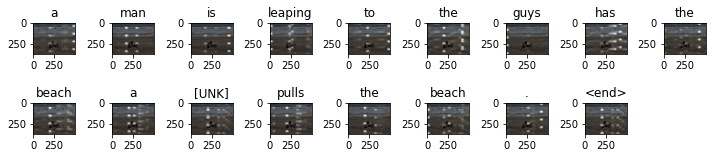

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> a young couple relaxing against a stone wall . <end>
Prediction Caption: a child sitting in a dark ball . <end>


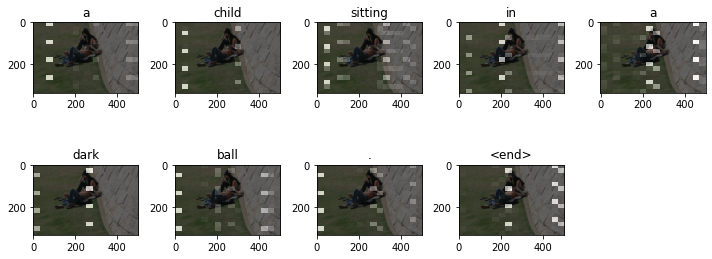

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> two kids sit on a seesaw . <end>
Prediction Caption: four enjoy guards laps while a large platform . <end>


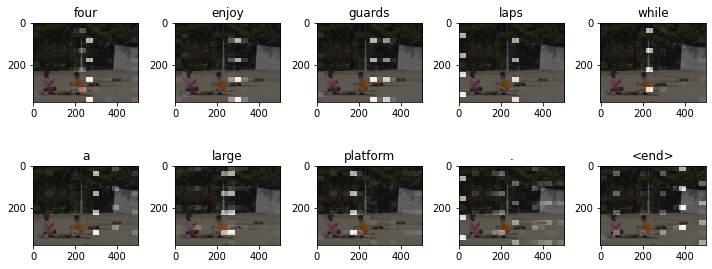

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy())
                         for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

#### Comments

Παρατηρείται ότι για το δείγμα εικόνων που χρησιμοποιήθηκε, για την ίδια εικόνα, η προβλεπόμενη περιγραφή δεν προκύπτει σε κάθε εκτέλεση του κελιού η ίδια. Ωστόσο,  μια καλή πρόβλεψη θα παραμείνει καλή σε κάθε νέα εκτέλεση κελιού και αντίστοιχα και για μια κακή πρόβλεψη.

# Evaluation of Captioning Quality with BLEU (Bilingual Evaluation Understudy) score between hypothesis (caption of NN) and references (real caption)

BLEU score is a metric for text model evaluation.

It gives a number between 0 and 1 which represents the similarity of the produced texts from the models in contradiction with some good captions. If it is 0, it means that there was no overlap between the words of the predicted and the real text, else if is 1, it means the opposite.

For the implementation we used NLTK from [nltk.translate.bleu_score](https://www.nltk.org/_modules/nltk/translate/bleu_score.html) which gives: 
- _sentence_bleu_ , for the evaluation of captioning of a singular example
- _corpus_bleu_ , for the evaluation of captioning of image set

Parameters used: weights=(0.4, 0.3, 0.2, 0.1), smoothing_function=SmoothingFunction().method1

#### Για να αξιολογήσουμε την ποιότητα των captions θα χρησιμοποιήσουμε την μετρική bleu. Αρχικά μεμομενομένα με την χρήση της sentence bleu και έπειτα γενικευμένα με το corpus bleu.

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
weights=(0.4, 0.3, 0.2, 0.1)
reference = [['a', 'man' ,'and', 'a', 'woman', 'are', 'sorting', 'through', 'laundry', 'with', 'latex', 'gloves', 'on']]
candidate = ['a', 'dude', 'is', 'wearing', 'gloves', ',', 'which', 'looks', 'on']
smoothie = SmoothingFunction().method1
score = sentence_bleu(reference, candidate, weights,smoothing_function = smoothie)
score

0.03150431195854521

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
weights=(0.4, 0.3, 0.2, 0.1)
reference = [['a', 'family', 'sits', 'on', 'the', 'beach', 'together']]
candidate = ['a', 'man', 'is', 'leaping', 'to', 'the', 'guys', 'has', 'the', 'beach', 'a', '[UNK]', 'pulls', 'the', 'beach']
smoothie = SmoothingFunction().method1
score = sentence_bleu(reference, candidate, weights,smoothing_function = smoothie)
score

0.055701487422709584

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
weights=(0.4, 0.3, 0.2, 0.1)
reference = [['a', 'young', 'couple', 'relaxing', 'against', 'a', 'stone','wall']]
candidate = ['a', 'child', 'sitting', 'in', 'a', 'dark', 'ball']
smoothie = SmoothingFunction().method1
score = sentence_bleu(reference, candidate, weights,smoothing_function = smoothie)
score

0.048627880223044685

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
weights=(0.4, 0.3, 0.2, 0.1)
reference = [['two', 'kids', 'sit', 'on', 'a', 'seesaw']]
candidate = ['four', 'enjoy', 'guards', 'laps', 'while', 'a', 'large', 'platform']
smoothie = SmoothingFunction().method1
score = sentence_bleu(reference, candidate, weights,smoothing_function = smoothie)
score

0.036283347037395386

## Corpus_bleu

In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

9.087472706154126e-05

### Comments:
Παρατηρούμε πως έχουμε πολύ άσχημο αποτέλεσμα γεγονός που μας δίνει περιθώριο για βελτιστοποιήσεις.

### Optimizations

Θα προσπαθήσουμε να βελτιώσουμε όλα τα σημεία της ανάλυσής μας ξεκινώντας από την καλύτερη προεπεξεργασία κειμένου αλλά και με την χρήση διαφορετικών encoder και decoder.

In [ ]:
def initialize_model(embedding_dim, units, learning_rate, tokenizer):
    encoder = CNN_Encoder(embedding_dim)
    decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    return encoder, decoder, optimizer

### Text preprocessing

- captions with word length in range(25,35)
- text size of vocabulary: 7.500 words.
- in standardize add filter lemmatization

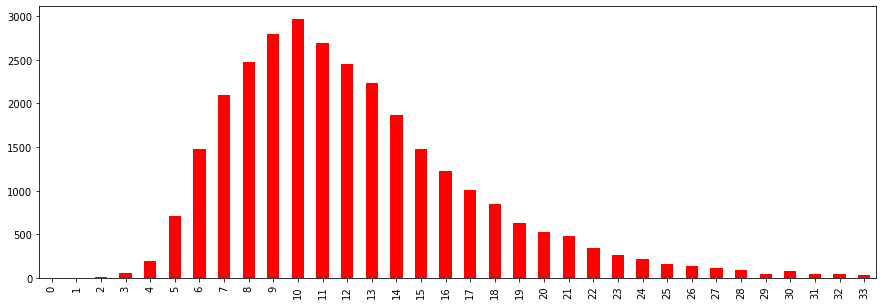

In [ ]:
histogram = np.zeros(80, 'int')
for i in range(len(train_captions)):
    caption_length = len(train_captions[i].split(" "))-3
    histogram[caption_length] += 1

df = pd.DataFrame(histogram[:34])
df.plot(kind='bar', stacked=False, color='Red', legend=False, figsize=(15, 5))
plt.show()

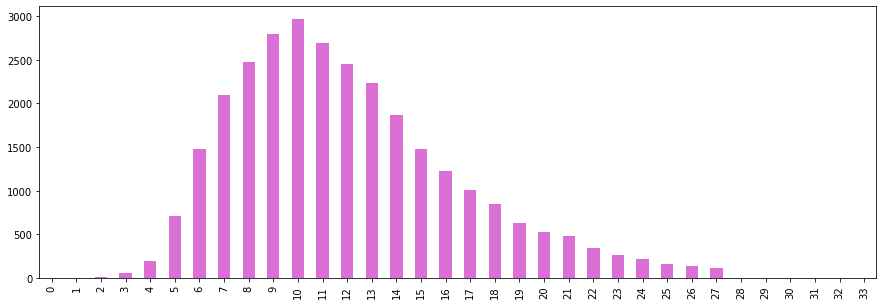

Before:  30000 30000
After:   29479 29479


In [ ]:
train_captions_1 = []
img_name_vector_1 = []
min_cap = 5
max_cap = 30
histogram = np.zeros(80, 'int')

for i in range(len(train_captions)):
    caption_length = len(train_captions[i].split(" "))
    
    if (caption_length >= min_cap and caption_length <= max_cap):
        train_captions_1.append(train_captions[i])
        img_name_vector_1.append(img_name_vector[i])

for i in range(len(train_captions_1)):
    caption_length = len(train_captions_1[i].split(" "))-3
    histogram[caption_length] += 1

df = pd.DataFrame(histogram[:34])
df.plot(kind='bar', stacked=False, color='Orchid', legend=False, figsize=(15, 5))
plt.show()

print("Before: ", len(train_captions), len(img_name_vector))
print("After:  ", len(train_captions_1), len(img_name_vector_1))

### Encoder

For better performance, from the tutorial, we use a CNN model from Keras as encoder.

Θα χρησιμοποιήσουμε το pretrained μοντέλο NASNetLarge

In [ ]:
image_model = tf.keras.applications.NASNetLarge(include_top=False,
                                             weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
print(image_model)
print(new_input)
print(hidden_layer)
print(image_features_extract_model)

KerasTensor(type_spec=TensorSpec(shape=(None, 331, 331, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11, 11, 4032), dtype=tf.float32, name=None), name='activation_707/Relu:0', description="created by layer 'activation_707'")


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# These two variables represent that vector shape
#features_shape = 2048
#attention_features_shape = 100     not the real ones

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())
optimizer = tf.keras.optimizers.Adam()

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.3165
Epoch 1 Batch 100 Loss 1.4288
Epoch 1 Loss 1.506222
Time taken for 1 epoch 137.28 sec

Epoch 2 Batch 0 Loss 1.2774
Epoch 2 Batch 100 Loss 1.0629
Epoch 2 Loss 1.217624
Time taken for 1 epoch 59.17 sec

Epoch 3 Batch 0 Loss 1.2683
Epoch 3 Batch 100 Loss 1.0426
Epoch 3 Loss 1.085924
Time taken for 1 epoch 59.18 sec

Epoch 4 Batch 0 Loss 0.8798
Epoch 4 Batch 100 Loss 0.9447
Epoch 4 Loss 0.993226
Time taken for 1 epoch 59.44 sec

Epoch 5 Batch 0 Loss 1.0621
Epoch 5 Batch 100 Loss 0.8124
Epoch 5 Loss 0.918792
Time taken for 1 epoch 59.14 sec

Epoch 6 Batch 0 Loss 0.8718
Epoch 6 Batch 100 Loss 0.8291
Epoch 6 Loss 0.852980
Time taken for 1 epoch 59.23 sec

Epoch 7 Batch 0 Loss 0.8098
Epoch 7 Batch 100 Loss 0.8296
Epoch 7 Loss 0.794350
Time taken for 1 epoch 59.34 sec

Epoch 8 Batch 0 Loss 0.8010
Epoch 8 Batch 100 Loss 0.7169
Epoch 8 Loss 0.739210
Time taken for 1 epoch 59.41 sec

Epoch 9 Batch 0 Loss 0.7504
Epoch 9 Batch 100 Loss 0.6594
Epoch 9 Loss 0.690034
Time ta

In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

0.03382334818423583

### Embeddings 

In [ ]:
for i in list(api.info()['models'].keys()):
    print(i)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
embeddings_model = api.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((10000, EMBEDDING_DIM))
lr=1e-3
EPOCHS = 20

for idx, word in enumerate(tokenizer.get_vocabulary()):
    try:
        embedding_vector = embeddings_model[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[idx] = vec

In [ ]:
embedding_matrix.shape

(10000, 300)

In [ ]:
pretrained_embedding_layer = tf.keras.layers.Embedding(10000,
                                                       EMBEDDING_DIM,
                                                       weights=[embedding_matrix],
                                                       trainable=False)

In [ ]:
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=units,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.5296
Epoch 1 Batch 100 Loss 1.2315
Epoch 1 Loss 1.426196
Time taken for 1 epoch 89.39 sec

Epoch 2 Batch 0 Loss 1.2319
Epoch 2 Batch 100 Loss 1.0046
Epoch 2 Loss 1.132048
Time taken for 1 epoch 23.34 sec

Epoch 3 Batch 0 Loss 1.0359
Epoch 3 Batch 100 Loss 1.0311
Epoch 3 Loss 1.021193
Time taken for 1 epoch 23.39 sec

Epoch 4 Batch 0 Loss 0.8938
Epoch 4 Batch 100 Loss 0.9632
Epoch 4 Loss 0.938784
Time taken for 1 epoch 23.63 sec

Epoch 5 Batch 0 Loss 0.8636
Epoch 5 Batch 100 Loss 0.7977
Epoch 5 Loss 0.863673
Time taken for 1 epoch 23.67 sec

Epoch 6 Batch 0 Loss 0.7898
Epoch 6 Batch 100 Loss 0.7068
Epoch 6 Loss 0.797384
Time taken for 1 epoch 23.72 sec

Epoch 7 Batch 0 Loss 0.8338
Epoch 7 Batch 100 Loss 0.6587
Epoch 7 Loss 0.735821
Time taken for 1 epoch 23.85 sec

Epoch 8 Batch 0 Loss 0.7378
Epoch 8 Batch 100 Loss 0.6432
Epoch 8 Loss 0.680489
Time taken for 1 epoch 23.77 sec

Epoch 9 Batch 0 Loss 0.6776
Epoch 9 Batch 100 Loss 0.5917
Epoch 9 Loss 0.629730
Time tak

In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

0.11101999460183783

### Decoder

Πειραματιζόμαστε με τις μονάδες GRU (το tutorial χρησιμοποιει 512)

#### 1024 units

In [ ]:
pretrained_embedding_layer = tf.keras.layers.Embedding(10000,
                                                       EMBEDDING_DIM,
                                                       weights=[embedding_matrix],
                                                       trainable=False)

In [ ]:
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=1024,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.5667
Epoch 1 Batch 100 Loss 1.1364
Epoch 1 Loss 1.340853
Time taken for 1 epoch 105.33 sec

Epoch 2 Batch 0 Loss 1.2844
Epoch 2 Batch 100 Loss 1.0206
Epoch 2 Loss 1.087424
Time taken for 1 epoch 42.60 sec

Epoch 3 Batch 0 Loss 1.0340
Epoch 3 Batch 100 Loss 1.0596
Epoch 3 Loss 0.982269
Time taken for 1 epoch 42.84 sec

Epoch 4 Batch 0 Loss 0.9340
Epoch 4 Batch 100 Loss 1.0059
Epoch 4 Loss 0.901783
Time taken for 1 epoch 43.82 sec

Epoch 5 Batch 0 Loss 0.8642
Epoch 5 Batch 100 Loss 0.7090
Epoch 5 Loss 0.829930
Time taken for 1 epoch 43.83 sec

Epoch 6 Batch 0 Loss 0.8113
Epoch 6 Batch 100 Loss 0.8047
Epoch 6 Loss 0.768992
Time taken for 1 epoch 43.83 sec

Epoch 7 Batch 0 Loss 0.6971
Epoch 7 Batch 100 Loss 0.7430
Epoch 7 Loss 0.712375
Time taken for 1 epoch 43.86 sec

Epoch 8 Batch 0 Loss 0.6810
Epoch 8 Batch 100 Loss 0.6725
Epoch 8 Loss 0.662406
Time taken for 1 epoch 43.87 sec

Epoch 9 Batch 0 Loss 0.6606
Epoch 9 Batch 100 Loss 0.6104
Epoch 9 Loss 0.614947
Time ta

In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

#### 2048 units

In [ ]:
pretrained_embedding_layer = tf.keras.layers.Embedding(10000,
                                                       EMBEDDING_DIM,
                                                       weights=[embedding_matrix],
                                                       trainable=False)

In [ ]:
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=2048,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.3388
Epoch 1 Batch 100 Loss 1.2861
Epoch 1 Loss 1.383397
Time taken for 1 epoch 156.11 sec

Epoch 2 Batch 0 Loss 1.1749
Epoch 2 Batch 100 Loss 1.0235
Epoch 2 Loss 1.101888
Time taken for 1 epoch 93.12 sec

Epoch 3 Batch 0 Loss 1.0659
Epoch 3 Batch 100 Loss 0.9971
Epoch 3 Loss 1.001934
Time taken for 1 epoch 94.52 sec

Epoch 4 Batch 0 Loss 1.0376
Epoch 4 Batch 100 Loss 0.9042
Epoch 4 Loss 0.927742
Time taken for 1 epoch 95.29 sec

Epoch 5 Batch 0 Loss 0.8620
Epoch 5 Batch 100 Loss 0.8639
Epoch 5 Loss 0.866144
Time taken for 1 epoch 95.54 sec

Epoch 6 Batch 0 Loss 0.7902
Epoch 6 Batch 100 Loss 0.7651
Epoch 6 Loss 0.811932
Time taken for 1 epoch 95.59 sec

Epoch 7 Batch 0 Loss 0.7177
Epoch 7 Batch 100 Loss 0.7761
Epoch 7 Loss 0.761316
Time taken for 1 epoch 95.47 sec

Epoch 8 Batch 0 Loss 0.6935
Epoch 8 Batch 100 Loss 0.7641
Epoch 8 Loss 0.718347
Time taken for 1 epoch 95.56 sec

Epoch 9 Batch 0 Loss 0.6375
Epoch 9 Batch 100 Loss 0.6222
Epoch 9 Loss 0.677855
Time ta

In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

0.12303484758823342

### LSTM

In [ ]:
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                               units=1024,
                                               tokenizer=tokenizer,
                                               learning_rate=lr)
decoder.embedding = pretrained_embedding_layer
decoder.gru = tf.keras.layers.LSTM(decoder.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

### Final model

In [ ]:
EMBEDDING_DIM = 300
pretrained_embedding_layer = tf.keras.layers.Embedding(10000,
                                                       EMBEDDING_DIM,
                                                       weights=[embedding_matrix],
                                                       trainable=False)

In [ ]:
encoder, decoder, optimizer = initialize_model(embedding_dim=EMBEDDING_DIM,
                                         units=1024,
                                         tokenizer=tokenizer,
                                         learning_rate=lr)
decoder.embedding = pretrained_embedding_layer


In [ ]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target,encoder,decoder,optimizer)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.2775
Epoch 1 Batch 100 Loss 1.2027
Epoch 1 Loss 1.365723
Time taken for 1 epoch 179.98 sec

Epoch 2 Batch 0 Loss 1.0815
Epoch 2 Batch 100 Loss 1.0280
Epoch 2 Loss 1.099738
Time taken for 1 epoch 100.58 sec

Epoch 3 Batch 0 Loss 1.0473
Epoch 3 Batch 100 Loss 0.9697
Epoch 3 Loss 0.992188
Time taken for 1 epoch 100.56 sec

Epoch 4 Batch 0 Loss 0.9255
Epoch 4 Batch 100 Loss 0.9724
Epoch 4 Loss 0.910776
Time taken for 1 epoch 100.64 sec

Epoch 5 Batch 0 Loss 0.8332
Epoch 5 Batch 100 Loss 0.7997
Epoch 5 Loss 0.841005
Time taken for 1 epoch 100.57 sec

Epoch 6 Batch 0 Loss 0.8622
Epoch 6 Batch 100 Loss 0.7941
Epoch 6 Loss 0.779575
Time taken for 1 epoch 100.63 sec

Epoch 7 Batch 0 Loss 0.7094
Epoch 7 Batch 100 Loss 0.6079
Epoch 7 Loss 0.726448
Time taken for 1 epoch 100.57 sec

Epoch 8 Batch 0 Loss 0.7024
Epoch 8 Batch 100 Loss 0.7353
Epoch 8 Loss 0.678502
Time taken for 1 epoch 100.66 sec

Epoch 9 Batch 0 Loss 0.6024
Epoch 9 Batch 100 Loss 0.6294
Epoch 9 Loss 0.630935


In [ ]:
# Blue Score for whole validation set
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1
weights=(0.4, 0.3, 0.2, 0.1)

def BLEU_Score():
    list_of_references = [[[tf.compat.as_text(index_to_word(i).numpy()) 
                                for i in caption if i not in [0]] 
                                for caption in img_to_cap_vector[image]]
                                for image in img_name_val_keys]
    hypotheses = [evaluate(image)[0] for image in img_name_val_keys]
    return corpus_bleu(list_of_references, hypotheses, weights, smoothing_function=smoothie)

BLEU_Score()

0.1258709243058208

## **Results, Comments, Report**

Παρακάτω θα περιγράψουμε τις αποφάσεις που πήραμε σχετικά με την βελτίωση των αποτελεσμάτων και θα παραθέσουμε μερικές τιμές από τις δοκιμές που έγιναν και δεν φαίνονται στο παραπάνω notebook.

#### **Προεπεξεργασία κειμένου** :
Το tutorial χρησιμοποιεί μέγιστο μήκος λέξεων 50. Με βάση το ιστόγραμμα που υλοποιήθηκε παραπάνω επιλέξαμε να κρατήσουμε μήκη από 5 έως 30 λέξεις. Επιπλέον το tutorial χρησιμοποιεί ένα vocabulary 5000 λέξεων. Δοκιμάσαμε τις τιμές 6000,8000 και 10000 και παρατηρήσαμε καλύτερα αποτελέσματα στις 10000. Επιπλέον αύξηση μπορεί να επιφέρει ακόμα καλύτερα αποτελέσματα μέχρι ενός ορίου. Δεν δοκιμάστηκε vocabulary λιγότερων λέξεων καθώς ήταν ξεκάθαρο πως θα λειτουργούσε ανασταλτικά.

#### **Encoder** :
Χρησιμοποιήθηκε το μοντέλο NASNetLarge και παρουσίασε καλύτερα αποτελέσματα από το InceptionV3, πιθανώς καθώς έχει εκπαιδευτεί σε πολύ μεγαλύτερο αριθμό δεδομένων.

#### **Embeddings** :
Η χρήση των embeddings βοήθησε ιδιαίτερα στην μείωση του χρόνου εκπαίδευσης καθώς και στην βελτίωση του corpus_bleu. Χρησιμοποιήθηκαν 3 δειαφορετικά μοντέλα του Genism τα οποία φαίνονται παρακάτω. Παρατηρήθηκε πως τα διαφορετικά μήκη δεν παρουσίαζαν αισθητή διαφορά μεταξύ τους και κρατήσαμε αυτό με μήκος 300 επειδή είχε ελάχιστα καλύτερο αποτέλεσμα.

#### **Decoder** :

Σε αυτό το στάδιο πειραματιστήκαμε τόσο με διαφορετικούς τύπους decoder, LSTM και GRU όσο και με τα units του καθενός. Καταλήξαμε στο συμπέρασμα οτι ο τύπος αποκωδικοποιητή δεν έπαιξε πολύ μεγάλο ρόλο, καθώς επίσης και οτι όσον αφορά τις μονάδες όσο περισσότερες χρησιμοποιούσαμε είχαμε μικρή βελτίωση του μοντέλου μας. Παρόλα αυτά παρατηρήθηκε πως ο διπλασιασμός των μονάδων οδηγεί και σε διπλασμό του χρόνου εκπαίδευσης του μοντέλου μας. Το tutorial χρησιμοποιει GRU 512 units και εμείς επιλέξαμε GRU 1024 units καθώς είχε το καλύτερο trade-off αποτελέσματος-χρόνου εκπαίδευσης. 

#### **Regularization** :

It was implemented with Dropout: [nn.Droupout](https://wandb.ai/authors/ayusht/reports/Implementing-Dropout-in-PyTorch-With-Example--VmlldzoxNTgwOTE).

Πειραματιστήκαμε επίσης με την εισαγωγή dropout και παρατηρήθηκε πως βελτιώνει ελάχιστα το μοντέλο μας για τις τιμές 0.4-0.5. Παρόλα αυτά δεν χρησιμοποιήθηκε στο τελικό μας μοντέλο καθώς είχαμε περιορισμένους πόρους.

#### **Overfit**:

Στα πειράματά μας χρησιμοποιήσαμε λίγες εποχές για την εκπαίδευση, καθώς παρατηρήσαμε πως όσο περισσότερες χρησιμοποιούμε τόσο η απόδοση του μοντέλου χειροτέρευε (BLEU score). Πιθανή εξήγηση αυτού του φαινομένου είναι ότι το μοντέλο μας έκανε overfit λόγω του μεγάλου αριθμού παραμέτρων.

Επιπλέον παρατηρήθηκε πως μείωση του batch size διπλασίαζε τον χρόνο εκπαίδευσης.

#### **Τελικό μοντέλο** :

Το τελικό μοντέλο που επιλέχθηκε είναι το εξής :


Encoder : NASNetLarge , Decoder : GRU 1024 units, 'glove-wiki-gigaword-300' , 10000 vocabulary size. (dropout 0.4)

#### **Experimentation** :
Παρακάτω παραθέτουμε έναν συνοπτικό πίνακα με δίαφορες δοκιμές και τα αντίστοιχα scores, καθώς και μια μετρική για τον χρόνο εκτέλεσης. Όσον αφορά τον χρόνο χρησιμοποιούμε το σύβολο + για αναλογικά λίγο χρόνο, τα ++ για μεσαίο και τα +++ για ιδαιάτερα μεγάλο training. 

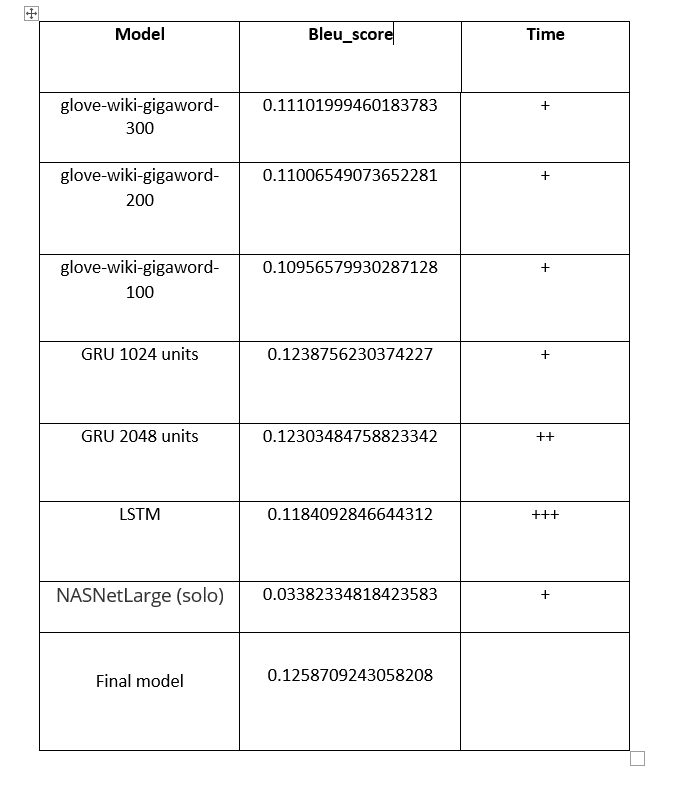

#### **Γενικές ιδέες και συμπεράσματα** :

Το πρόβλημα του image captioning είναι γενικά ένα ιδιαίτερα δύσκολο πρόβλημα το οποίο απασχολεί ερευνητικά και διευρύνεται συνεχώς. Οι δυσκολίες του εντοπίζονται κυρίως στο ότι τα dataset είναι πολύ μεγάλα αλλά και στο ότι αποτελεί συνδυασμός προβλήματος nlp και computer vision. Αυτή είναι μια εξήγηση για τα σχετικά χαμηλά scores που παρατηρούμε.

Στην εργασία αυτή αντιμετωπίστηκαν διάφορων ειδών προβλήματα, κυρίως με το google colab το οποίο ενίοτε crashare, αλλά και με την αυξημένη απαίτηση σε gpu (χρειάστηκαν 4 accounts), με το disc usage αλλά και το drive memory. Για αυτόν τον λόγο επιλέξαμε να παραμείνουμε στις 6000 εικόνες και να έχουμε πιθανώς χαμηλότερα scores (λόγω λιγότερων δειγμάτων εκπαίδευσης).